# Dataset Download and Extraction

In [1]:
!pip install -qU googledrivedownloader silence-tensorflow

In [2]:
import os
import shutil

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1wfBL7YGEeMNcJz0p5lljQvr5VmZJuxGe',
                                    dest_path=f'/content/traffic.zip',
                                    unzip=True)

os.remove('traffic.zip')

Unzipping...Done.


# Required libraries download 

In [4]:
!pip install -qU imgaug==0.2.6
!pip install -qU opencv-contrib-python
!pip install -qU scikit-image
!pip install -qU imutils

     |████████████████████████████████| 634kB 3.5MB/s 
     |████████████████████████████████| 49.9MB 55kB/s 
     |████████████████████████████████| 12.4MB 245kB/s 


# Model Building

In [5]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [6]:
def build_model(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    channelDim = -1
    
    model.add(Conv2D(8, (5, 5), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channelDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization(axis=channelDim))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization(axis=channelDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization(axis=channelDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # second set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes, activation='relu'))
    model.add(Activation("softmax"))

    return model
    

# Image Preprocessing building data loader

In [7]:
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report

from skimage import transform
from skimage import exposure
from skimage import io

import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [8]:
def load_split(basePath, csvPath):
    data = []
    labels = []
    rows = open(csvPath).read().strip().split("\n")[1:]
    random.shuffle(rows)
    
    for i, row in enumerate(rows):
        (label, imagePath) = row.strip().split(",")[-2:]
        imagePath = os.path.sep.join([basePath, imagePath])
        image = io.imread(imagePath)

        # resize the image to be 32x32 pixels, ignoring aspect ratio,
        # and then perform Contrast Limited Adaptive Histogram
        # Equalization (CLAHE)
        
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)

        data.append(image)
        labels.append(int(label))
    
    print(f"Processed {i} total images")
        
    data = np.array(data)
    labels = np.array(labels)
    
    return (data, labels)

In [9]:
# constants

NUM_EPOCHS = 30
INIT_LR = 1e-3
batch_size = 64

In [10]:
# load the label names

labelNames = open("/content/gtsrb-german-traffic-sign/signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

dataset_path = r'/content/gtsrb-german-traffic-sign'
train_path = r"/content/gtsrb-german-traffic-sign/Train.csv"
test_path = r"/content/gtsrb-german-traffic-sign/Test.csv"
labelNames

['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)']

In [11]:
# load the training and testing data
print("Loading training and testing data...")
(trainX, trainY) = load_split(dataset_path, train_path)
(testX, testY) = load_split(dataset_path, test_path)

Loading training and testing data...
Processed 13199 total images
Processed 4319 total images


In [12]:
# scale the images to the range of [0, 1]

trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [13]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(13200, 32, 32, 3)
(13200,)
(4320, 32, 32, 3)
(4320,)


In [14]:
# one-hot encode the training and testing labels

numLabels = len(np.unique(trainY))
print(numLabels)
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

9


In [15]:
print(trainY.shape)
print(testY.shape)

(13200, 9)
(4320, 9)


In [16]:
# accounting for skewness in the labeled data

classTotals = trainY.sum(axis=0)
# print(classTotals)
classWeight = classTotals.max() / classTotals
# print(classWeight)
classWeight = {i: x for i, x  in enumerate(classWeight)}

# for key, val in classWeight.items():
#     print(key, val, end="||")

In [17]:
# adding image augmentation

train_datagen = ImageDataGenerator(
    rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest"
)

train_generator = train_datagen.flow(trainX, trainY, batch_size=batch_size)

In [18]:
optimizer = Adam(lr=INIT_LR, decay=INIT_LR/(NUM_EPOCHS*0.5))

model = build_model(width=32, height=32, depth=3, classes=numLabels)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [19]:
# model Training

history = model.fit(
    train_generator,
    steps_per_epoch=trainX.shape[0] // batch_size,
    validation_data=(testX, testY),
    epochs=NUM_EPOCHS,
    class_weight=classWeight
)

Epoch 1/30
206/206 [==============================] - 11s 52ms/step - loss: 3.6030 - accuracy: 0.1575 - val_loss: 3.1630 - val_accuracy: 0.1042
Epoch 2/30
206/206 [==============================] - 10s 49ms/step - loss: 2.9119 - accuracy: 0.2392 - val_loss: 6.5565 - val_accuracy: 0.1042
Epoch 3/30
206/206 [==============================] - 10s 49ms/step - loss: 2.3968 - accuracy: 0.3653 - val_loss: 4.8042 - val_accuracy: 0.0808
Epoch 4/30
206/206 [==============================] - 10s 50ms/step - loss: 1.8605 - accuracy: 0.5107 - val_loss: 0.9626 - val_accuracy: 0.6699
Epoch 5/30
206/206 [==============================] - 10s 49ms/step - loss: 1.4772 - accuracy: 0.6223 - val_loss: 1.0894 - val_accuracy: 0.6315
Epoch 6/30
206/206 [==============================] - 10s 49ms/step - loss: 1.1819 - accuracy: 0.7010 - val_loss: 0.6356 - val_accuracy: 0.7725
Epoch 7/30
206/206 [==============================] - 10s 49ms/step - loss: 0.9967 - accuracy: 0.7547 - val_loss: 0.4955 - val_accuracy:

In [20]:
# evaluate model

predictions = model.predict(testX, batch_size=batch_size)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1), target_names=labelNames))

                             precision    recall  f1-score   support

       Speed limit (20km/h)       0.98      1.00      0.99        60
       Speed limit (30km/h)       0.99      0.97      0.98       720
       Speed limit (50km/h)       0.93      0.99      0.96       750
       Speed limit (60km/h)       0.99      0.90      0.94       450
       Speed limit (70km/h)       0.99      0.97      0.98       660
       Speed limit (80km/h)       0.92      0.92      0.92       630
End of speed limit (80km/h)       0.97      0.96      0.97       150
      Speed limit (100km/h)       0.96      0.96      0.96       450
      Speed limit (120km/h)       0.94      0.97      0.95       450

                   accuracy                           0.96      4320
                  macro avg       0.96      0.96      0.96      4320
               weighted avg       0.96      0.96      0.96      4320



In [26]:
# saving model
import tensorflow as tf
SAVE_PATH = 'speed_limit_model/'

tf.saved_model.save(model, SAVE_PATH)

INFO:tensorflow:Assets written to: speed_limit_model/assets


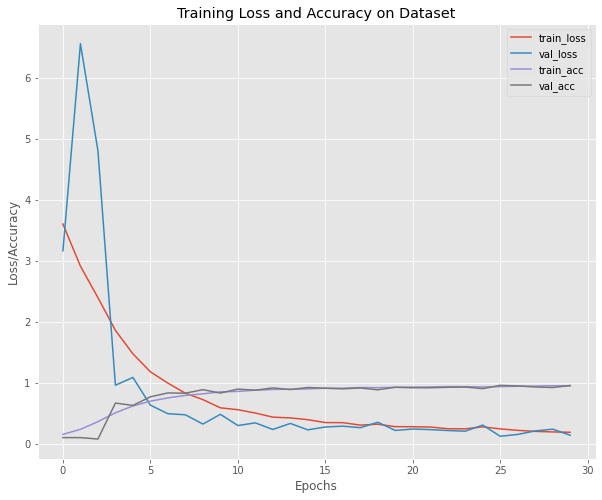

In [27]:
%matplotlib inline

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(10, 8))
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

# Prediction on sample images

In [28]:
from tensorflow.keras.models import load_model
import cv2
from imutils import paths
import imutils
from google.colab.patches import cv2_imshow

In [29]:
model = load_model(SAVE_PATH)

In [37]:
!zip -r speed_limit_model speed_limit_model/

updating: speed_limit_model/ (stored 0%)
  adding: speed_limit_model/assets/ (stored 0%)
  adding: speed_limit_model/variables/ (stored 0%)
  adding: speed_limit_model/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: speed_limit_model/variables/variables.index (deflated 74%)
  adding: speed_limit_model/variables/variables.data-00000-of-00002 (deflated 82%)
  adding: speed_limit_model/saved_model.pb (deflated 90%)


In [41]:
!unzip speed_limit_model.zip -d speed_

Archive:  speed_limit_model.zip
   creating: speed_/speed_limit_model/
   creating: speed_/speed_limit_model/assets/
   creating: speed_/speed_limit_model/variables/
  inflating: speed_/speed_limit_model/variables/variables.data-00001-of-00002  
  inflating: speed_/speed_limit_model/variables/variables.index  
  inflating: speed_/speed_limit_model/variables/variables.data-00000-of-00002  
  inflating: speed_/speed_limit_model/saved_model.pb  
